In [215]:
import random
import matplotlib.pyplot as plt
import numpy as np
import copy

In [216]:

names = [
    "Kerry",
    "James",
    "Kyle",
    "Sarah",
    "Frank",
    "Hazel",
    "Casey",
    "Gerald",
    "Mary",
    "Merry",
    "Bonnie",
    "John",
    "Jeremy",
    "Geraldine",
    "Gerry",
    "Finnian",
    "Fiona",
    "Poe",
    "Tuvok",
    "Turlough",
    "Tess",
    "Vivian",
    "Violet",
    "Christine",
    "Kir",
    "Chloe",
    "Conor"
]

class Scenario():
    
    def __init__(self, limit = None, exact = False, verbrose = True):
        self.randomize(limit, exact)
        self.verbrose = verbrose
        
    def randomize(self, limit = None, exact = False):

        self.debts = {}
        self.reset_stats()

        pairs = [(i, j) for i in range(len(names)) for j in range(i + 1, len(names))]
        
        if limit == None or limit > len(pairs):
            limit = len(pairs)

        if limit > 0 and not exact:
            limit = random.randrange(limit)
            
        for _ in range(limit):
            
            k = random.randrange(len(pairs))
            i, j = pairs.pop(k)
    
            amount = 10 * (1 + random.randrange(5)) * random.choice([1, -1])
            self.debts[i,j] = amount
            
        self.normalize()
        
        self.initial_count = len(self.debts)
        self.initial_amount = 0
        for pair in self.debts:
            self.initial_amount += self.debts[pair]
          
    def normalize(self):

        # Check that everything doesn't just cancel out
        balances = [0] * len(names)
        for i,j in list(self.debts):
            amount = self.debts[i,j]
            balances[i] -= amount
            balances[j] += amount

        # If it does cancel out, clear debts
        if all([x == 0 for x in balances]):
            self.debts = dict()

        # Negative debts can be positive debts
        # going the other way
        for i,j in list(self.debts):
            if self.debts[i,j] < 0:
                if not ((j,i) in self.debts):
                    self.debts[j,i] = 0
                self.debts[j,i] -= self.debts[i,j]
                del self.debts[i,j]
        
        # If there is debt going both ways,
        # that can be simplified to a single debt
        for i in range(len(names)):
            for j in range(i, len(names)):

                if i == j:
                    if (i,i) in self.debts:
                        del self.debts[i,i]
                        
                elif ((i,j) in self.debts) and ((j,i) in self.debts):
                    balance = self.debts[i,j] - self.debts[j,i]
                    if balance > 0:
                        self.debts[i,j] = balance
                        del self.debts[j,i]
                    elif balance < 0:
                        self.debts[j,i] = -balance
                        del self.debts[i,j]
                    else:
                        del self.debts[i,j]
                        del self.debts[j,i]

    def state(self):
        
        if not self.verbrose:
            return

        print("=====")

        if len(self.debts) == 0:
            print("All has been settled")

        else:
            for i,j in self.debts:
                debitor = names[i]
                creditor = names[j]
                value = self.debts[i,j]
                print(debitor, "owes", creditor, value)

        print("=====")
            
    def reset_stats(self):
        self.initial_count = 0
        self.transactions = 0
        self.transferred = 0

    def stats(self):
        
        if not self.verbrose:
            return
        
        print("Initial amount:", self.initial_amount)
        print("Initial count:", self.initial_count)
        print("Total transactions:", self.transactions)
        print("Total transferred:", self.transferred)
    
    def pay(self, i, j, amount):
        self.transactions += 1
        self.transferred += abs(amount)

        if self.verbrose: 
            print("-----")
            print(names[i], "pays", names[j], amount)
            print("-----")
        
        debts = self.debts
        
        if ((i,j) in debts) and ((j,i) in debts):
            balance = debts[i,j] - debts[j,i]

        balance = 0

        if (i,j) in debts:
            balance = debts[i,j]

        if (j,i) in debts:
            balance -= debts[j,i]

        balance -= amount

        if balance > 0:
            #print(names[i], "now owes", names[j], balance)
            debts[i,j] = balance
            if (j,i) in debts: del debts[j,i]
        elif balance < 0:
            #print(names[j], "now owes", names[i], abs(balance))
            if (i,j) in debts: del debts[i,j]
            debts[j,i] = abs(balance)
        else:
            if (i,j) in debts: del debts[i,j]
            if (i,j) in debts: del debts[j,i]
            #print("Debt between", names[i], "and", 
            #      names[j], "has been settled")


In [198]:
def sol_simple(s: Scenario):
    # Simplest possible soln
    for i,j in list(s.debts):
        s.pay(i,j,s.debts[i,j])

s = Scenario(8)
s.state()

sol_simple(s)

s.state()
s.stats()

# Obviously this can be very very inefficient - take
# a triangle of debt:

# (0,1): 10
# (1,2): 10
# (2,0): 10

# That can be cleared on the spot without any transactions at all!
# New goal: only do the required number of transactions

=====
Kerry owes Jeremy 20
Merry owes John 10
=====
=====
All has been settled
=====
Initial amount: 30
Initial count: 2
Total transactions: 2
Total transferred: 30


In [241]:
def test(methods, domain):
    
    results = [[] for method in methods]
    
    for n in domain:
        
        template = Scenario(n, exact=True, verbrose=False)
        
        for i, method in enumerate(methods):
            run = copy.deepcopy(template)
            method(run)
            results[i].append(run.transactions)
            
    return results

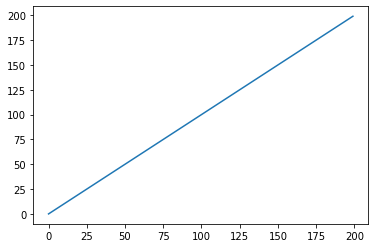

In [278]:
n = np.arange(200)

count, = apply((sol_simple,), n)

plt.plot(n, count)

# Yup, number of transactions equals number of debts

In [238]:
# Idea: find the desired end state
# (work from global balances rather than end depts)

class Accounts():
    
    def __init__(self, s: Scenario):
        self.calculate_balances(s)
        self.verbrose = s.verbrose
        
    def calculate_balances(self, s: Scenario):
        
        balances = [0] * len(names)
    
        for i,j in list(s.debts):
            amount = s.debts[i,j]
            balances[i] -= amount
            balances[j] += amount
            
        self.balances = balances
    

    def state(self):

        if not self.verbrose:
            return
        
        balances = self.balances
        
        print("=====")

        none = True

        for name, balance in zip(names, balances):

            if balance > 0:
                print(name, "should recieve", balance)
                none = False
            elif balance < 0:
                print(name, "should pay", -balance)
                none = False

        if none:
            print("No action required")

        print("=====")

S = Scenario(5)
A = Accounts(S)

S.state()
A.state()

=====
Gerald owes Tuvok 30
Finnian owes James 50
=====
=====
James should recieve 50
Gerald should pay 30
Finnian should pay 50
Tuvok should recieve 30
=====


In [251]:
# A naive way to execute the final step would be to have everyone
# who should pay put money in a central pile (or choose one person
# as center) and then have the center pay out to those who should recieve

# This solution is O(m) to compute, where m <= n**2
# It requires p actions to execute in the way described above. p <= n.
# I guess is an improvement over the n^2 possible transactions required before
# It also reduces circular graphs, which is a plus

# It's asymptotic behaviour is much better, but for small numbers the first
# simplest method usually produces better results!

def sol_central(S: Scenario):
    
    A = Accounts(S)
    A.state()
    
    if len(S.debts) != 0:

        balances = A.balances

        if S.verbrose:
            print(" <> Paying in to center")

        for i in range(1, len(balances)):
            balance = balances[i]
            if balance < 0:
                S.pay(i, 0, abs(balance))
                balances[i] = 0
                balances[0] -= abs(balance)

        if S.verbrose:
            print(" <> Paying out from center")

        for i in range(1, len(balances)):
            balance = balances[i]
            if balance > 0:
                S.pay(0, i, balance)
                balances[i] = 0
                balances[0] += balance
                
        #A.state()
    
S = Scenario(10)
S.state()

sol_central(S)

S.normalize()
S.state()
S.stats()
    

=====
Frank owes Tuvok 50
Chloe owes Casey 40
=====
=====
Frank should pay 50
Casey should recieve 40
Tuvok should recieve 50
Chloe should pay 40
=====
 <> Paying in to center
-----
Frank pays Kerry 50
-----
-----
Chloe pays Kerry 40
-----
 <> Paying out from center
-----
Kerry pays Casey 40
-----
-----
Kerry pays Tuvok 50
-----
=====
All has been settled
=====
Initial amount: 90
Initial count: 2
Total transactions: 4
Total transferred: 180


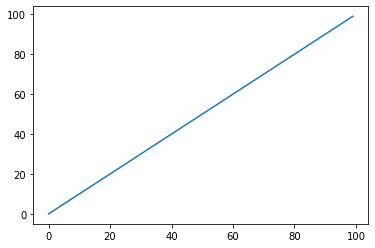

In [252]:
n = np.arange(100)
count = []

for ni in n:
    s = Scenario(ni, exact=True, verbrose=False)
    sol_simple(s)
    count.append(s.transactions)

plt.plot(n, count)

In [257]:
# The above case works and reduces the amount that needs to be transfers,
# but it is far from optimal

# Illustrative example:
# 0 +10
# 1 -10
# 2 +20
# 3 -20
# 4 +30
# 5 -30

# The above is easily done in 3 steps, instead of 6 using
# the centralized method.

# Here is a more direct approach

def sol_direct(S):
    
    A = Accounts(S)
    A.state()

    debtors = []
    creditors = []

    balances = A.balances

    for i, balance in enumerate(balances):
        if balance > 0:
            creditors.append(i)
        elif balance < 0:
            debtors.append(i)

    while len(debtors) > 0:

        debtor = debtors[0]
        d_amount = abs(balances[debtor])

        # This is nasty in terms of complexity - 
        # it means something like O((n^2)*log(n)) 
        creditors.sort(key=lambda x:abs(x-d_amount))

        creditor = creditors[0]
        c_amount = abs(balances[creditor])

        if d_amount > c_amount:
            S.pay(debtor, creditor, c_amount)
            balances[debtor] += c_amount
            balances[creditor] = 0
            creditors.pop(0)
        else:
            S.pay(debtor, creditor, d_amount)
            balances[debtor] = 0
            balances[creditor] -= d_amount
            debtors.pop(0)

    A.state()

S = Scenario(10)
S.state()

sol_direct(S)
    
S.normalize()
S.state()
S.stats()

=====
Sarah owes Gerald 30
Sarah owes Tess 50
Kyle owes John 20
Gerry owes Gerald 50
=====
=====
Kyle should pay 20
Sarah should pay 80
Gerald should recieve 80
John should recieve 20
Gerry should pay 50
Tess should recieve 50
=====
-----
Kyle pays Tess 20
-----
-----
Sarah pays Tess 30
-----
-----
Sarah pays John 20
-----
-----
Sarah pays Gerald 30
-----
-----
Gerry pays Gerald 50
-----
=====
No action required
=====
=====
All has been settled
=====
Initial amount: 150
Initial count: 4
Total transactions: 5
Total transferred: 150


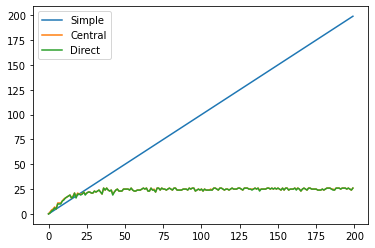

In [279]:

n = range(200)
results = test((sol_simple, sol_central, sol_direct), n)

for result, name in zip(results, ("Simple", "Central", "Direct")):
    plt.plot(n, result, label=name)
    
plt.legend()

# So when the number of debts is larger than the number of people,
# the central/direct methods take the lead

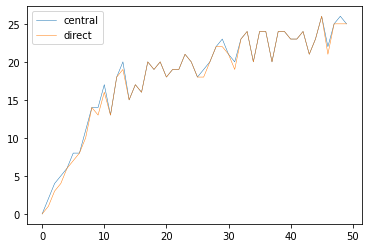

In [277]:

n = range(0, 50)
direct, central = test((sol_direct, sol_central), n)

plt.plot(n, central, "-", label="central", linewidth=0.5)
plt.plot(n, direct, "-", label="direct", linewidth=0.5)

plt.legend()

# Well, the direct method isn't really much better, 
# which surprises me